In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import random as rn
import matplotlib.pyplot as plt
from gurobipy import *
import numpy as np
import seaborn as sn

In [2]:
plt.rcParams["figure.figsize"] = (10,6)
plt.style.use("fivethirtyeight")
plt.rcParams.update({'figure.autolayout': True})

In [3]:
path = "C:/Users/garg1/Desktop/IAC Jupyter Files/demand_profile.csv";

#importing demand profile
demand_profile = pd.read_csv(path,header=None);
demand_profile = demand_profile.iloc[:50,:].copy()
nr_cust,nr_t = demand_profile.shape;

#demand_profile = demand_profile*2

#getting demand of the customers
demand = demand_profile.sum(axis=1).values;

#getting mean hourly demand of each customer
mean_hourly = np.rint(demand_profile.mean(axis=1).values)


# Loading Data Related to fuel
path = "C:/Users/garg1/Desktop/IAC Jupyter Files/fuel_properties.csv";
data2 = pd.read_csv(path);
data2['Eff- kWh/$/CO2'] = data2['kWh/Unit Fuel']*100/data2['Unit Price']/data2['CO2 lbs/Fuel Unit']
data2['Eff- kWh/$'] = data2['kWh/Unit Fuel']*100/data2['Unit Price']

#getting length of the data
nr_fuel = len(data2.index);

alpha_rate = list(data2["kWh/Unit Fuel"].values) #capturing kWh/fuel source
beta_rate = list(data2["CO2 lbs/Fuel Unit"].values) #capturing CO2 lbs/fuel source

fuel_supply=[]
capacities = [.50, .60, .20]
for i in range(nr_fuel):
    fuel_supply.append(round(demand.sum()*(capacities[i]/alpha_rate[i]),ndigits=0))
    

#other fuel properties
cost_fuel = list(data2["Unit Price"].values) #capturing cost of unit fuel source

cost_ramp = 0.50; #ramping up or down cost

caligraphy_n = 24; #maximum number of price change allowed

#epsilon_rate = round(np.median(mean_hourly),ndigits=0); #maximum ramping allowed at no cost

epsilon_rate = round(np.median(mean_hourly),ndigits=0); #maximum ramping allowed at no cost

cost_gamma = [10,10,10,10,15,15,15,15,20,20,20,20,20,10,10,10,10,10,10,15,15,15,10,10]
#cost_gamma = [5,5,5,5,10,10,10,10,15,15,15,15,15,5,5,5,5,5,5,15,15,15,10,10]


cost_emission = 10;  #Penalty cost of CO2 emisisons

#inconvenience cost to the customer
cost_xi=pd.DataFrame(0,index=np.arange(nr_cust),columns=np.arange(nr_t));

#Maximum overconsumption allowed more than psi
omega_rate=pd.DataFrame(0,index=np.arange(nr_cust),columns=np.arange(nr_t));

for i in range(nr_cust):
    n = demand_profile.iloc[i,:].max()
    m = demand_profile.iloc[i,:].mean()
    for t in range(nr_t):
        r = demand_profile.iloc[i,t]
        cost_xi.iloc[i,t] = abs(round((1-(r/n)),ndigits=2))
        omega_rate.iloc[i,t] = abs(round(r*(1-r/n)*1,ndigits=0))
        
times=range(nr_t)
fuels=range(nr_fuel)
customers=range(nr_cust)

psi_values = [5000, 70000,180000] #low, Medium, High Psi Values

In [4]:
cust_cost_comp = []

for k in range(nr_cust):
    cust_cost_comp.append(sum(demand_profile.T.iloc[:,k]*cost_gamma))

In [5]:
low_MCE_leader = pd.read_csv('low_MCE_leader.csv', index_col='Day-hours')
low_MCE_wh = pd.read_csv('low_MCE_wh.csv', index_col='Day-hours')
low_MCE_wl = pd.read_csv('low_MCE_wl.csv', index_col='Day-hours')
low_MCE_vplus = pd.read_csv('low_MCE_vplus.csv', index_col='Day-hours')
low_MCE_vminus = pd.read_csv('low_MCE_vminus.csv', index_col='Day-hours')
low_MCE_ukt = pd.read_csv('low_MCE_ukt.csv', index_col='Day-hours')

low_MWCE_leader = pd.read_csv('low_MWCE_leader.csv', index_col='Day-hours')
low_MWCE_wh = pd.read_csv('low_MWCE_wh.csv', index_col='Day-hours')
low_MWCE_wl = pd.read_csv('low_MWCE_wl.csv', index_col='Day-hours')
low_MWCE_vplus = pd.read_csv('low_MWCE_vplus.csv', index_col='Day-hours')
low_MWCE_vminus = pd.read_csv('low_MWCE_vminus.csv', index_col='Day-hours')
low_MWCE_ukt = pd.read_csv('low_MWCE_ukt.csv', index_col='Day-hours')

In [6]:
med_MCE_leader = pd.read_csv('med_MCE_leader.csv', index_col='Day-hours')
med_MCE_wh = pd.read_csv('med_MCE_wh.csv', index_col='Day-hours')
med_MCE_wl = pd.read_csv('med_MCE_wl.csv', index_col='Day-hours')
med_MCE_vplus = pd.read_csv('med_MCE_vplus.csv', index_col='Day-hours')
med_MCE_vminus = pd.read_csv('med_MCE_vminus.csv', index_col='Day-hours')
med_MCE_ukt = pd.read_csv('med_MCE_ukt.csv', index_col='Day-hours')

med_MWCE_leader = pd.read_csv('med_MWCE_leader.csv', index_col='Day-hours')
med_MWCE_wh = pd.read_csv('med_MWCE_wh.csv', index_col='Day-hours')
med_MWCE_wl = pd.read_csv('med_MWCE_wl.csv', index_col='Day-hours')
med_MWCE_vplus = pd.read_csv('med_MWCE_vplus.csv', index_col='Day-hours')
med_MWCE_vminus = pd.read_csv('med_MWCE_vminus.csv', index_col='Day-hours')
med_MWCE_ukt = pd.read_csv('med_MWCE_ukt.csv', index_col='Day-hours')

In [7]:
df_46 = med_MCE_wh.iloc[:,46]+med_MCE_wl.iloc[:,46]+med_MCE_vminus.iloc[:,46]-med_MCE_vplus.iloc[:,46] 

low_cost = sum(med_MCE_wl.iloc[:,46]*med_MCE_leader['Low_Price'])
high_cost = sum(med_MCE_wh.iloc[:,46]*med_MCE_leader['High_Price'])
inc_cost = sum(med_MCE_vplus.iloc[:,46]*cost_xi.T.iloc[:,46])
(low_cost+high_cost+inc_cost)/1e6

25.699962850000002

In [8]:
high_MCE_leader = pd.read_csv('high_MCE_leader.csv', index_col='Day-hours')
high_MCE_wh = pd.read_csv('high_MCE_wh.csv', index_col='Day-hours')
high_MCE_wl = pd.read_csv('high_MCE_wl.csv', index_col='Day-hours')
high_MCE_vplus = pd.read_csv('high_MCE_vplus.csv', index_col='Day-hours')
high_MCE_vminus = pd.read_csv('high_MCE_vminus.csv', index_col='Day-hours')
high_MCE_ukt = pd.read_csv('high_MCE_ukt.csv', index_col='Day-hours')

high_MWCE_leader = pd.read_csv('high_MWCE_leader.csv', index_col='Day-hours')
high_MWCE_wh = pd.read_csv('high_MWCE_wh.csv', index_col='Day-hours')
high_MWCE_wl = pd.read_csv('high_MWCE_wl.csv', index_col='Day-hours')
high_MWCE_vplus = pd.read_csv('high_MWCE_vplus.csv', index_col='Day-hours')
high_MWCE_vminus = pd.read_csv('high_MWCE_vminus.csv', index_col='Day-hours')
high_MWCE_ukt = pd.read_csv('high_MWCE_ukt.csv', index_col='Day-hours')

In [9]:
def plot_rates(low_MCE_leader, med_MCE_leader, high_MCE_leader,
               low_MWCE_leader, med_MWCE_leader, high_MWCE_leader, 
               xaxis=times, comp_cost=cost_gamma, psi=psi_values):
    
    title_row = ['With CE', 'Without CE']
    psi_labels = ['Low \u03C8', 'Medium \u03C8', 'High \u03C8']
    pad = 5 # in points

    fig, axes = plt.subplots(1,2, figsize=(16,8), constrained_layout=True, sharey='row', sharex= True)

    axes[0].plot(low_MCE_leader['Low_Price'], label='Low-Price', alpha= 1)
    axes[0].plot(low_MCE_leader['High_Price'], label='High-Price', alpha= 1, ls='--')
    axes[0].plot(comp_cost, label='Comp-Price', alpha= 0.75, ls=':', c='k')
    axes[0].set_ylabel('cents/kWh')
    axes[0].set_xlabel('Day Hours')
    axes[0].set_xticks(np.arange(0, 24, step=2))
    axes[0].legend()
    axes[0].set_title('With_CE')
    
    axes[1].plot(low_MWCE_leader['Low_Price'], label='Low-Price', alpha= 1)
    axes[1].plot(low_MWCE_leader['High_Price'], label='High-Price', alpha= 1, ls='--')
    axes[1].plot(comp_cost, label='Comp-Price', alpha= 0.75, ls=':', c='k')
    axes[1].set_xticks(np.arange(0, 24, step=2))
    axes[1].set_xlabel('Day Hours')
    axes[1].legend()
    axes[1].set_title('Without_CE')
    fig.suptitle(f'Low \u03C8- {psi[0]}', fontsize=24);
    
    plt.savefig('low_psi.jpg',quality=95)
    
    plt.clf();
    
    fig, axes = plt.subplots(1,2, figsize=(16,8), constrained_layout=True, sharey='row', sharex= True)

    axes[0].plot(med_MCE_leader['Low_Price'], label='Low-Price', alpha= 1)
    axes[0].plot(med_MCE_leader['High_Price'], label='High-Price', alpha= 1, ls='--')
    axes[0].plot(comp_cost, label='Comp-Price', alpha= 0.75, ls=':', c='k')
    axes[0].set_ylabel('cents/kWh')
    axes[0].set_xlabel('Day Hours')
    axes[0].set_xticks(np.arange(0, 24, step=2))
    axes[0].legend()
    axes[0].set_title('With_CE')
    
    axes[1].plot(med_MWCE_leader['Low_Price'], label='Low-Price', alpha= 1)
    axes[1].plot(med_MWCE_leader['High_Price'], label='High-Price', alpha= 1, ls='--')
    axes[1].plot(comp_cost, label='Comp-Price', alpha= 0.75, ls=':', c='k')
    axes[1].set_xticks(np.arange(0, 24, step=2))
    axes[1].set_xlabel('Day Hours')
    axes[1].legend()
    axes[1].set_title('Without_CE')
    fig.suptitle(f'Medium \u03C8- {psi[1]}', fontsize=24);
    
    plt.savefig('med_psi.jpg',quality=95)
    
    plt.clf();
    
    fig, axes = plt.subplots(1,2, figsize=(16,8), constrained_layout=True, sharey='row', sharex= True)

    axes[0].plot(high_MCE_leader['Low_Price'], label='Low-Price', alpha= 1)
    axes[0].plot(high_MCE_leader['High_Price'], label='High-Price', alpha= 1, ls='--')
    axes[0].plot(comp_cost, label='Comp-Price', alpha= 0.75, ls=':', c='k')
    axes[0].set_ylabel('cents/kWh')
    axes[0].set_xlabel('Day Hours')
    axes[0].set_xticks(np.arange(0, 24, step=2))
    axes[0].legend()
    axes[0].set_title('With_CE')
    
    axes[1].plot(high_MWCE_leader['Low_Price'], label='Low-Price', alpha= 1)
    axes[1].plot(high_MWCE_leader['High_Price'], label='High-Price', alpha= 1, ls='--')
    axes[1].plot(comp_cost, label='Comp-Price', alpha= 0.75, ls=':', c='k')
    axes[1].set_xticks(np.arange(0, 24, step=2))
    axes[1].set_xlabel('Day Hours')
    axes[1].legend()
    axes[1].set_title('Without_CE')
    fig.suptitle(f'High \u03C8- {psi[2]}', fontsize=24);
    
    plt.savefig('high_psi.jpg',quality=95)
    

def plot_demands(low_MCE_leader, med_MCE_leader, high_MCE_leader,
               low_MWCE_leader, med_MWCE_leader, high_MWCE_leader, 
               xaxis=times, psi=psi_values):
    
    title_row = ['With CE', 'Without CE']
    psi_labels = ['Low \u03C8', 'Medium \u03C8', 'High \u03C8']
    pad = 5 # in points

    fig, axes = plt.subplots(1,2, figsize=(16,8), constrained_layout=True, sharey='row', sharex= True)

    axes[0].plot(low_MCE_leader['Low_Price Demand'], label='Low-Demand', alpha= 1)
    axes[0].plot(low_MCE_leader['High_Price_Demand'], label='High-Demand', alpha= 1, ls='--')
    axes[0].plot(low_MCE_leader['Comp_Demand'], label='Comp-Demand', alpha= 0.75, ls=':', c='k')
    axes[0].set_ylabel('kWh/hr')
    axes[0].set_xlabel('Day Hours')
    axes[0].set_xticks(np.arange(0, 24, step=2))
    axes[0].legend()
    axes[0].set_title('With_CE')
    
    axes[1].plot(low_MWCE_leader['Low_Price Demand'], label='Low-Demand', alpha= 1)
    axes[1].plot(low_MWCE_leader['High_Price_Demand'], label='High-Demand', alpha= 1, ls='--')
    axes[1].plot(low_MWCE_leader['Comp_Demand'], label='Comp-Demand', alpha= 0.75, ls=':', c='k')
    axes[1].set_xticks(np.arange(0, 24, step=2))
    axes[1].set_xlabel('Day Hours')
    axes[1].legend()
    axes[1].set_title('Without_CE')
    fig.suptitle(f'Low \u03C8- {psi[0]}', fontsize=24);
    
    plt.savefig('low_psi_demand.jpg',quality=95)
    
    plt.clf();
    
    fig, axes = plt.subplots(1,2, figsize=(16,8), constrained_layout=True, sharey='row', sharex= True)

    axes[0].plot(med_MCE_leader['Low_Price Demand'], label='Low-Demand', alpha= 1)
    axes[0].plot(med_MCE_leader['High_Price_Demand'], label='High-Demand', alpha= 1, ls='--')
    axes[0].plot(med_MCE_leader['Comp_Demand'], label='Comp-Demand', alpha= 0.75, ls=':', c='k')
    axes[0].set_ylabel('kWh/hr')
    axes[0].set_xlabel('Day Hours')
    axes[0].set_xticks(np.arange(0, 24, step=2))
    axes[0].legend()
    axes[0].set_title('With_CE')
    
    axes[1].plot(med_MWCE_leader['Low_Price Demand'], label='Low-Demand', alpha= 1)
    axes[1].plot(med_MWCE_leader['High_Price_Demand'], label='High-Demand', alpha= 1, ls='--')
    axes[1].plot(med_MWCE_leader['Comp_Demand'], label='Comp-Demand', alpha= 0.75, ls=':', c='k')
    axes[1].set_xticks(np.arange(0, 24, step=2))
    axes[1].set_xlabel('Day Hours')
    axes[1].legend()
    axes[1].set_title('Without_CE')
    fig.suptitle(f'Medium \u03C8- {psi[1]}', fontsize=24);
    
    plt.savefig('med_psi_demand.jpg',quality=95)
    
    plt.clf();
    
    fig, axes = plt.subplots(1,2, figsize=(16,8), constrained_layout=True, sharey='row', sharex= True)

    axes[0].plot(high_MCE_leader['Low_Price Demand'], label='Low-Demand', alpha= 1)
    axes[0].plot(high_MCE_leader['High_Price_Demand'], label='High-Demand', alpha= 1, ls='--')
    axes[0].plot(high_MCE_leader['Comp_Demand'], label='Comp-Demand', alpha= 0.75, ls=':', c='k')
    axes[0].set_ylabel('kWh/hr')
    axes[0].set_xlabel('Day Hours')
    axes[0].set_xticks(np.arange(0, 24, step=2))
    axes[0].legend()
    axes[0].set_title('With_CE')
    
    axes[1].plot(high_MWCE_leader['Low_Price Demand'], label='Low-Demand', alpha= 1)
    axes[1].plot(high_MWCE_leader['High_Price_Demand'], label='High-Demand', alpha= 1, ls='--')
    axes[1].plot(high_MWCE_leader['Comp_Demand'], label='Comp-Demand', alpha= 0.75, ls=':', c='k')
    axes[1].set_xticks(np.arange(0, 24, step=2))
    axes[1].set_xlabel('Day Hours')
    axes[1].legend()
    axes[1].set_title('Without_CE')
    fig.suptitle(f'High \u03C8- {psi[2]}', fontsize=24);
    
    plt.savefig('high_psi_demand.jpg',quality=95)
    

    

def plot_demands_shifted(low_MCE_leader, med_MCE_leader, high_MCE_leader,
               low_MWCE_leader, med_MWCE_leader, high_MWCE_leader, 
               xaxis=times, psi=psi_values, d_demand = demand):
    
    title_row = ['With CE', 'Without CE']
    psi_labels = ['Low \u03C8', 'Medium \u03C8', 'High \u03C8']
    pad = 5 # in points

    fig, axes = plt.subplots(1,2, figsize=(16,8), constrained_layout=True, sharey='row', sharex= True)

    axes[0].plot(low_MCE_leader['Upward_Demand_Shifted'], label='Low-\u03C8', alpha= 1)
    axes[0].plot(med_MCE_leader['Upward_Demand_Shifted'], label='Medium-\u03C8', alpha= 1, ls='--')
    axes[0].plot(high_MCE_leader['Upward_Demand_Shifted'], label='High-\u03C8', alpha= 0.75, ls=':', c='k')
    axes[0].set_ylabel('kWh/hr')
    axes[0].set_xlabel('Day Hours')
    axes[0].set_xticks(np.arange(0, 24, step=2))
    axes[0].legend()
    axes[0].set_title('With_CE')
    
    axes[1].plot(low_MWCE_leader['Upward_Demand_Shifted'], label='Low-\u03C8', alpha= 1)
    axes[1].plot(med_MWCE_leader['Upward_Demand_Shifted'], label='Medium-\u03C8', alpha= 1, ls='--')
    axes[1].plot(high_MWCE_leader['Upward_Demand_Shifted'], label='High-\u03C8', alpha= 0.75, ls=':', c='k')
    axes[1].set_xticks(np.arange(0, 24, step=2))
    axes[1].set_xlabel('Day Hours')
    axes[1].legend()
    axes[1].set_title('Without_CE')
    
    fig.suptitle(f'Total Upward Demand Shifted', fontsize=24);
    
    plt.savefig('upward_shift.jpg',quality=95)
    
    plt.clf();
    
    fig, axes = plt.subplots(1,2, figsize=(16,8), constrained_layout=True, sharey='row', sharex= True)

    axes[0].plot(low_MCE_leader['Downward_Demand_Shifted'], label='Low-\u03C8', alpha= 1)
    axes[0].plot(med_MCE_leader['Downward_Demand_Shifted'], label='Medium-\u03C8', alpha= 1, ls='--')
    axes[0].plot(high_MCE_leader['Downward_Demand_Shifted'], label='High-\u03C8', alpha= 0.75, ls=':', c='k')
    axes[0].set_ylabel('kWh/hr')
    axes[0].set_xlabel('Day Hours')
    axes[0].set_xticks(np.arange(0, 24, step=2))
    axes[0].legend()
    axes[0].set_title('With_CE')
    
    axes[1].plot(low_MWCE_leader['Downward_Demand_Shifted'], label='Low-\u03C8', alpha= 1)
    axes[1].plot(med_MWCE_leader['Downward_Demand_Shifted'], label='Medium-\u03C8', alpha= 1, ls='--')
    axes[1].plot(high_MWCE_leader['Downward_Demand_Shifted'], label='High-\u03C8', alpha= 0.75, ls=':', c='k')
    axes[1].set_xticks(np.arange(0, 24, step=2))
    axes[1].set_xlabel('Day Hours')
    axes[1].legend()
    axes[1].set_title('Without_CE')
    
    fig.suptitle(f'Total Downward Demand Shifted', fontsize=24);
    
    plt.savefig('downward_shift.jpg',quality=95)
    
    MCE_low_shift_perc = sum(low_MCE_leader['Downward_Demand_Shifted'])*100/sum(d_demand)
    MCE_med_shift_perc = sum(med_MCE_leader['Downward_Demand_Shifted'])*100/sum(d_demand)
    MCE_high_shift_perc = sum(high_MCE_leader['Downward_Demand_Shifted'])*100/sum(d_demand)
    MWCE_low_shift_perc = sum(low_MWCE_leader['Downward_Demand_Shifted'])*100/sum(d_demand)
    MWCE_med_shift_perc = sum(med_MWCE_leader['Downward_Demand_Shifted'])*100/sum(d_demand)
    MWCE_high_shift_perc = sum(high_MWCE_leader['Downward_Demand_Shifted'])*100/sum(d_demand)
    
    return MCE_low_shift_perc, MCE_med_shift_perc, MCE_high_shift_perc, MWCE_low_shift_perc, MWCE_med_shift_perc, MWCE_high_shift_perc

    
df_wh, df_wl, df_vplus, df_vminus, df_ukt = low_MCE_wh, low_MCE_wl, low_MCE_vplus, low_MCE_vminus, low_MCE_ukt
pi_h, pi_l = low_MWCE_leader['High_Price'], low_MWCE_leader['Low_Price']

def cust_cost(df_wh, df_wl, df_vplus, df_vminus, df_ukt, pi_h, pi_l,
                  cost_comp=pd.DataFrame(cost_gamma),penalty_df=cost_xi.copy(), itr1=nr_cust):
    
    penalty_df = penalty_df.T.copy()
    cust = ['Cust'+str(j) for j in range(itr1)]
    dict_columns = dict(list(enumerate(cust)))
    penalty_df1 = penalty_df.rename(columns = dict_columns)
    
    cost_list = []
    
    for c in cust:
        a1 = sum(pi_h*df_wh[c])
        b1 = sum(pi_l*df_wl[c])
        c1 = sum(cost_comp*df_ukt[c])
        d1 = sum(df_vplus[c]*penalty_df1[c])
        cost_list.append(a1+b1+c1+d1)
        
    return cost_list
    
    

def plot_cust_penalty(low_MCE_vplus, med_MCE_vplus, high_MCE_vplus,
                     low_MWCE_vplus, med_MWCE_vplus, high_MWCE_vplus,penalty_cost=cost_xi.copy(), itr1=nr_cust):
    
    penalty_cost = penalty_cost.T.copy()
    cust = ['Cust'+str(j) for j in range(itr1)]
    dict_columns = dict(list(enumerate(cust)))
    penalty_cost1 = penalty_cost.rename(columns = dict_columns)
    
    title_row = ['With CE', 'Without CE']
    psi_labels = ['Low \u03C8', 'Medium \u03C8', 'High \u03C8']
    pad = 5 # in points
    
    low_MCE_inc = []
    med_MCE_inc = []
    high_MCE_inc = []
    low_MWCE_inc = []
    med_MWCE_inc = []
    high_MWCE_inc = []
    
    for c in cust:
        low_MCE_inc.append(sum(penalty_cost1[c]*low_MCE_vplus[c]))
        med_MCE_inc.append(sum(penalty_cost1[c]*med_MCE_vplus[c]))
        high_MCE_inc.append(sum(penalty_cost1[c]*high_MCE_vplus[c]))
        low_MWCE_inc.append(sum(penalty_cost1[c]*low_MWCE_vplus[c]))
        med_MWCE_inc.append(sum(penalty_cost1[c]*med_MWCE_vplus[c]))
        high_MWCE_inc.append(sum(penalty_cost1[c]*high_MWCE_vplus[c]))

    fig, axes = plt.subplots(1,2, figsize=(24,12), constrained_layout=True, sharey='row', sharex= True)

    df_sum = pd.DataFrame(index=range(nr_cust))
    df_sum['Low-\u03C8'] = low_MCE_inc
    df_sum['Medium-\u03C8'] = med_MCE_inc
    df_sum['High-\u03C8'] = high_MCE_inc
    df_sum.plot(kind='bar', grid=False, rot=0, xticks=np.arange(0, 50, step=5),subplots=False, ax=axes[0],
                title='With CE', width=0.75)
    axes[0].set_ylabel('cents')
    
    df_sum1 = pd.DataFrame(index=range(nr_cust))
    df_sum1['Low-\u03C8'] = low_MWCE_inc
    df_sum1['Medium-\u03C8'] = med_MWCE_inc
    df_sum1['High-\u03C8'] = high_MWCE_inc
    df_sum1.plot(kind='bar', grid=False, rot=0, xticks=np.arange(0, 50, step=5),subplots=False, ax=axes[1],
                title='Without CE', width=0.75)
    axes[1].set_ylabel('cents')
    axes[1].set_xlabel('Customers')
    
    fig.suptitle(f'Total Inconvenience Cost', fontsize=24);
    
    plt.savefig('inc_cost.jpg',quality=95)
    

def plot_cust_object(low_cust_MCE, med_cust_MCE, high_cust_MCE,
                    low_cust_MWCE, med_cust_MWCE, high_cust_MWCE,nr_cust):
    
    title_row = ['With CE', 'Without CE']
    psi_labels = ['Low \u03C8', 'Medium \u03C8', 'High \u03C8']
    pad = 5 # in points


    fig, axes = plt.subplots(2,1, figsize=(24,12), constrained_layout=True, sharey=True, sharex= True)

    df_sum = pd.DataFrame(index=range(nr_cust))
    df_sum['Low-\u03C8'] = low_cust_MCE
    df_sum['Medium-\u03C8'] = med_cust_MCE
    df_sum['High-\u03C8'] = high_cust_MCE
    df_sum.plot(kind='bar', grid=False, rot=0, xticks=np.arange(0, 50, step=5),subplots=False, ax=axes[0],
                title='With CE', width=0.75)
    axes[0].set_ylabel('cents')
    
    df_sum1 = pd.DataFrame(index=range(nr_cust))
    df_sum1['Low-\u03C8'] = low_cust_MWCE
    df_sum1['Medium-\u03C8'] = med_cust_MWCE
    df_sum1['High-\u03C8'] = high_cust_MWCE
    df_sum1.plot(kind='bar', grid=False, rot=0, xticks=np.arange(0, 50, step=5),subplots=False, ax=axes[1],
                title='Without CE', width=0.75)
    axes[1].set_ylabel('cents')
    axes[1].set_xlabel('Customers')
    
    fig.suptitle(f'Customer Total Cost', fontsize=24);
    
    plt.savefig('cust_obj_cost.jpg',quality=95);
    plt.clf();
    
    fig, axes = plt.subplots(3,1, figsize=(16,8), constrained_layout=True, sharey=True, sharex= True)
    df_diff = pd.DataFrame(index=range(nr_cust))
    df_diff['% Change_Low-\u03C8'] = (df_sum['Low-\u03C8']-df_sum1['Low-\u03C8'])*100/df_sum['Low-\u03C8']
    df_diff['% Change_Medium-\u03C8'] = (df_sum['Medium-\u03C8']-df_sum1['Medium-\u03C8'])*100/df_sum['Medium-\u03C8']
    df_diff['% Change_High-\u03C8'] = (df_sum['High-\u03C8']-df_sum1['High-\u03C8'])*100/df_sum['High-\u03C8']
    
    df_diff.plot(kind='bar', grid=True, rot=0, xticks=np.arange(0, 50, step=5),subplots=True, 
                 ax=axes[:], width=0.75, legend=None);
    
    fig.suptitle(f'% Change w.r.t. With CE', fontsize=24);
    plt.savefig('perc_change.jpg', quality=95,constrained_layout=True,)
    

def plot_cust_object_perc(low_cust_MCE, med_cust_MCE, high_cust_MCE,
                    low_cust_MWCE, med_cust_MWCE, high_cust_MWCE,nr_cust,cust_cost_comp):
    
    title_row = ['With CE', 'Without CE']
    psi_labels = ['Low \u03C8', 'Medium \u03C8', 'High \u03C8']
    pad = 5 # in points


    fig, axes = plt.subplots(3,2, figsize=(24,12), constrained_layout=True, sharey=True, sharex= True)

    df_sum = pd.DataFrame(index=range(nr_cust))
    df_sum['Comp-Price'] = cust_cost_comp
    df_sum['Low-\u03C8'] = low_cust_MCE
    df_sum['Medium-\u03C8'] = med_cust_MCE
    df_sum['High-\u03C8'] = high_cust_MCE
    
    df_sum['%_Low-\u03C8'] = (df_sum['Comp-Price']-df_sum['Low-\u03C8'])*100/df_sum['Comp-Price']
    df_sum['%_Medium-\u03C8'] = (df_sum['Comp-Price']-df_sum['Medium-\u03C8'])*100/df_sum['Comp-Price']
    df_sum['%_High-\u03C8'] = (df_sum['Comp-Price']-df_sum['High-\u03C8'])*100/df_sum['Comp-Price']
    
    df_sum.drop(columns = ['Comp-Price', 'Low-\u03C8', 'Medium-\u03C8', 'High-\u03C8'], axis=1, inplace=True)
    df_sum.plot(kind='bar', grid=False, rot=0, xticks=np.arange(0, 50, step=5),subplots=True, ax=axes[:,0],
                title=['With CE','',''], width=0.75)
    axes[0,0].set_ylabel('%')
    axes[1,0].set_ylabel('%')
    axes[2,0].set_ylabel('%')
    axes[0,0].set_xlabel('Customers')
    axes[1,0].set_xlabel('Customers')
    axes[2,0].set_xlabel('Customers')
    
    df_sum1 = pd.DataFrame(index=range(nr_cust))
    df_sum1['Comp-Price'] = cust_cost_comp
    df_sum1['Low-\u03C8'] = low_cust_MWCE
    df_sum1['Medium-\u03C8'] = med_cust_MWCE
    df_sum1['High-\u03C8'] = high_cust_MWCE
    
    df_sum1['%_Low-\u03C8'] = (df_sum1['Comp-Price']-df_sum1['Low-\u03C8'])*100/df_sum1['Comp-Price']
    df_sum1['%_Medium-\u03C8'] = (df_sum1['Comp-Price']-df_sum1['Medium-\u03C8'])*100/df_sum1['Comp-Price']
    df_sum1['%_High-\u03C8'] = (df_sum1['Comp-Price']-df_sum1['High-\u03C8'])*100/df_sum1['Comp-Price']
    
    df_sum1.drop(columns = ['Comp-Price', 'Low-\u03C8', 'Medium-\u03C8', 'High-\u03C8'], axis=1, inplace=True)
    
    df_sum1.plot(kind='bar', grid=False, rot=0, xticks=np.arange(0, 50, step=5),subplots=True, ax=axes[:,1],
                 title=['Without CE','',''], width=0.75)
    axes[0,1].set_xlabel('Customers')
    axes[1,1].set_xlabel('Customers')
    axes[2,1].set_xlabel('Customers')
    
    fig.suptitle(f'% Change Compared to Competitor', fontsize=24);
    
    plt.savefig('cust_obj_cost_perc.jpg',quality=95);

(14.192701404972018,
 20.152836683312202,
 20.152836683312202,
 17.074330886577638,
 20.152836683312202,
 20.152836683312202)

<Figure size 1152x576 with 0 Axes>

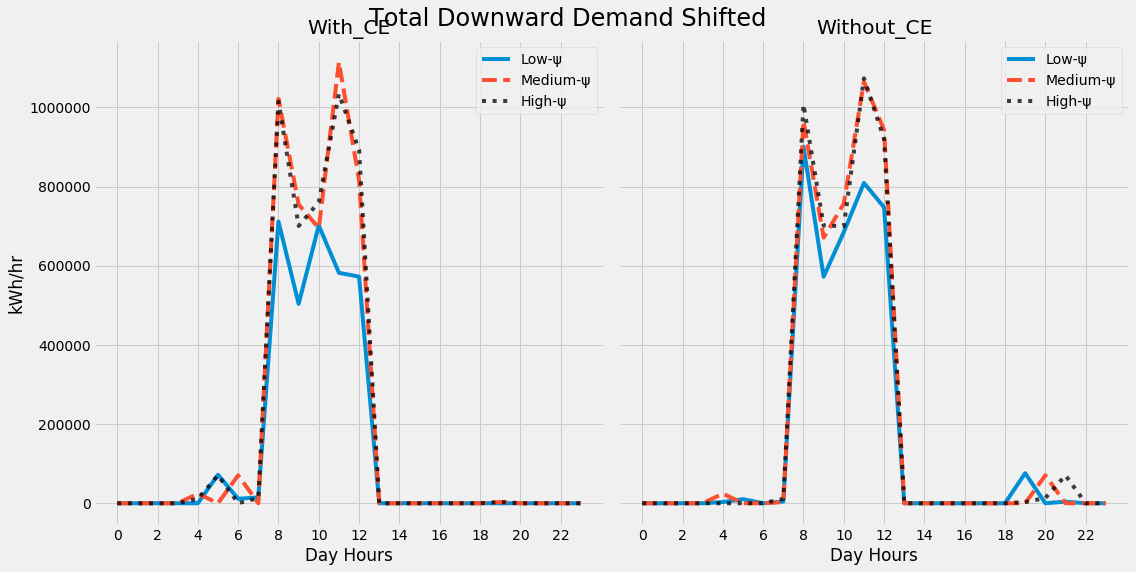

In [10]:
plot_demands_shifted(low_MCE_leader, med_MCE_leader, high_MCE_leader,low_MWCE_leader, med_MWCE_leader, high_MWCE_leader)


<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

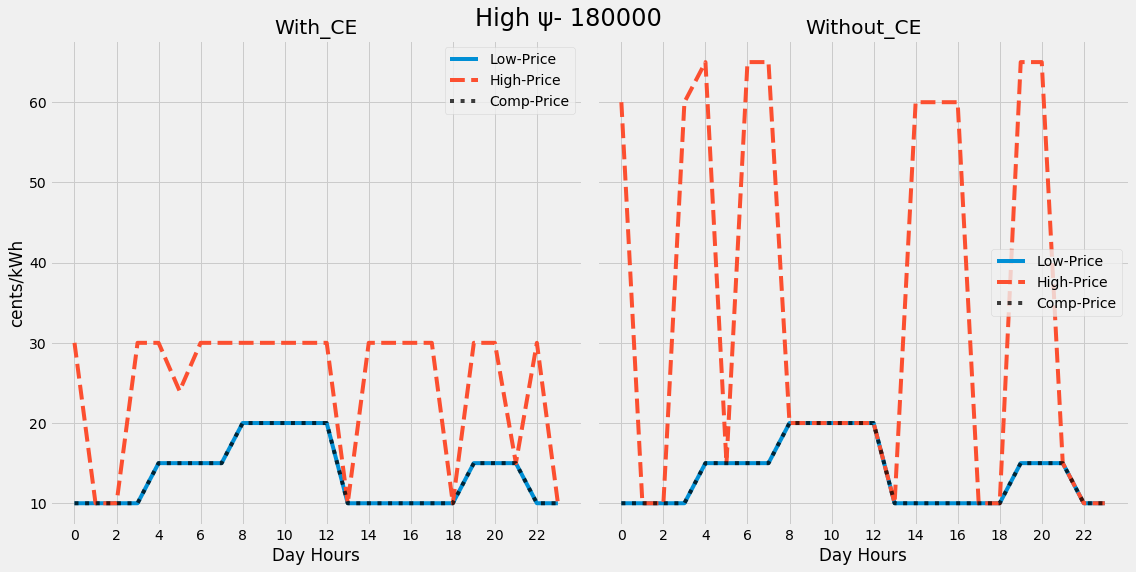

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

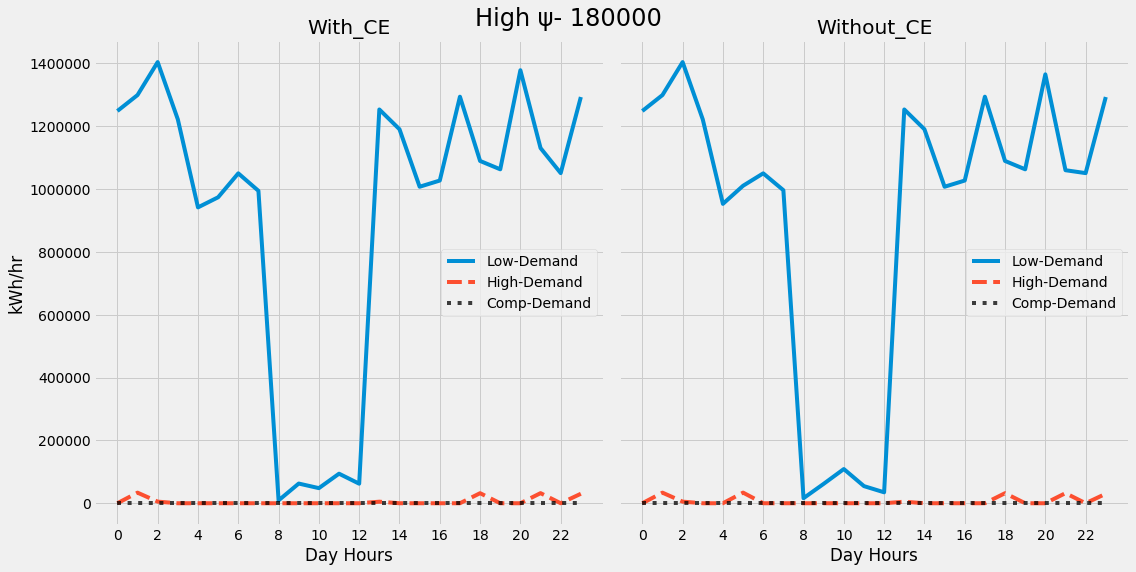

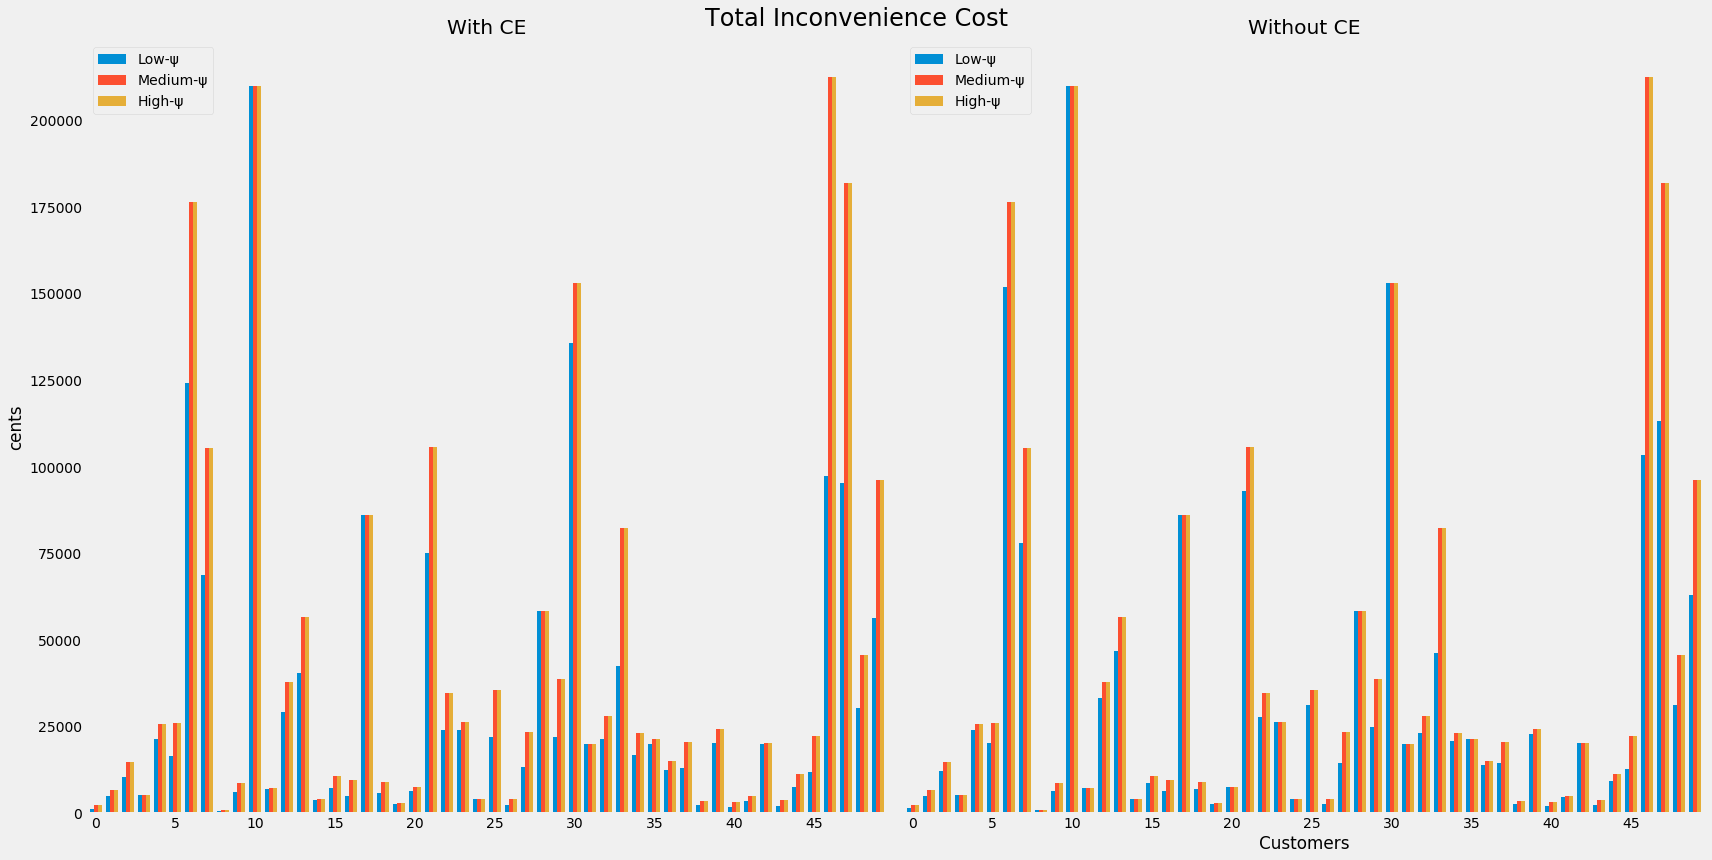

In [11]:
plot_rates(low_MCE_leader, med_MCE_leader, high_MCE_leader,low_MWCE_leader, med_MWCE_leader, high_MWCE_leader)

plot_demands(low_MCE_leader, med_MCE_leader, high_MCE_leader,low_MWCE_leader, med_MWCE_leader, high_MWCE_leader)

plot_cust_penalty(low_MCE_vplus, med_MCE_vplus, high_MCE_vplus,low_MWCE_vplus, med_MWCE_vplus, high_MWCE_vplus)

<Figure size 1728x864 with 0 Axes>

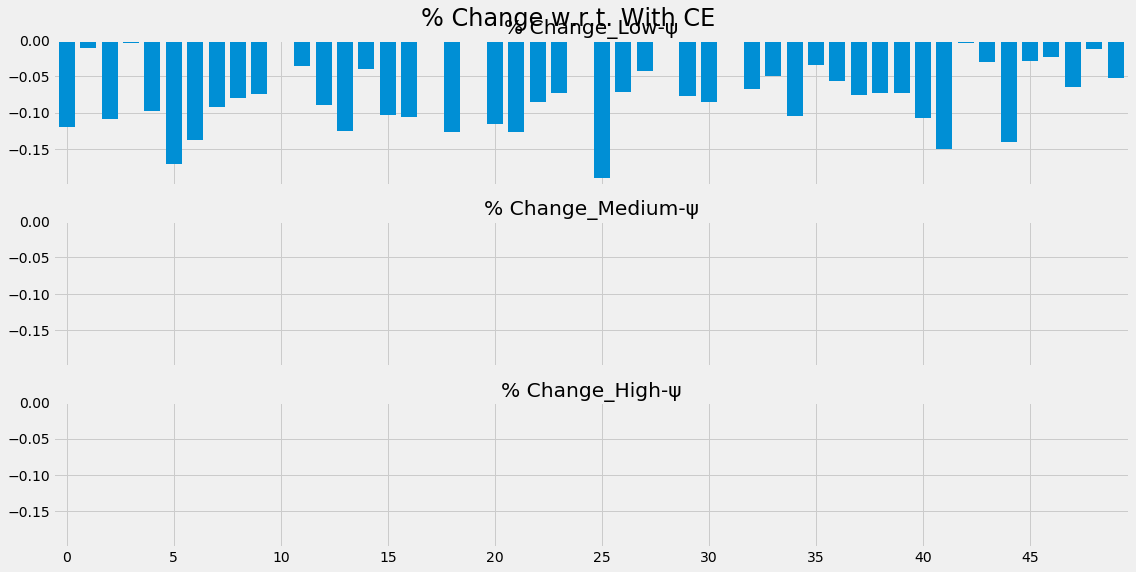

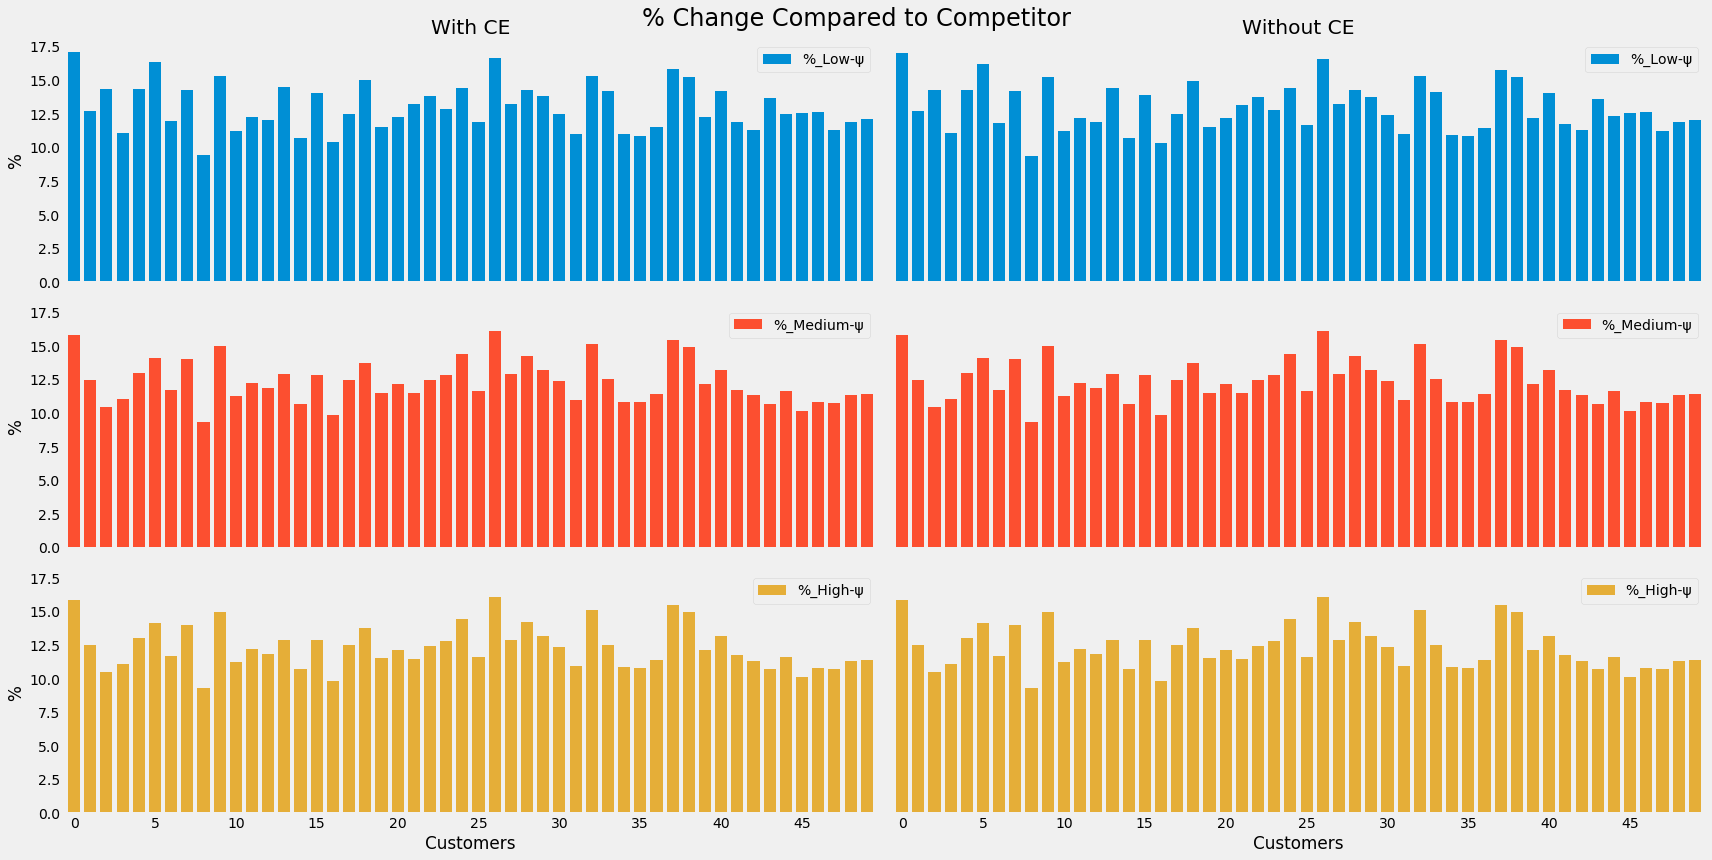

In [12]:
df_wh, df_wl, df_vplus, df_vminus, df_ukt = low_MCE_wh, low_MCE_wl, low_MCE_vplus, low_MCE_vminus, low_MCE_ukt
pi_h, pi_l = low_MCE_leader['High_Price'], low_MCE_leader['Low_Price']
low_cust_MCE = cust_cost(df_wh, df_wl, df_vplus, df_vminus, df_ukt, pi_h, pi_l)

df_wh, df_wl, df_vplus, df_vminus, df_ukt = med_MCE_wh, med_MCE_wl, med_MCE_vplus, med_MCE_vminus, med_MCE_ukt
pi_h, pi_l = med_MCE_leader['High_Price'], med_MCE_leader['Low_Price']
med_cust_MCE = cust_cost(df_wh, df_wl, df_vplus, df_vminus, df_ukt, pi_h, pi_l)

df_wh, df_wl, df_vplus, df_vminus, df_ukt = high_MCE_wh, high_MCE_wl, high_MCE_vplus, high_MCE_vminus, high_MCE_ukt
pi_h, pi_l = high_MCE_leader['High_Price'], high_MCE_leader['Low_Price']
high_cust_MCE = cust_cost(df_wh, df_wl, df_vplus, df_vminus, df_ukt, pi_h, pi_l)

df_wh, df_wl, df_vplus, df_vminus, df_ukt = low_MWCE_wh, low_MWCE_wl, low_MWCE_vplus, low_MWCE_vminus, low_MWCE_ukt
pi_h, pi_l = low_MWCE_leader['High_Price'], low_MWCE_leader['Low_Price']
low_cust_MWCE = cust_cost(df_wh, df_wl, df_vplus, df_vminus, df_ukt, pi_h, pi_l)

df_wh, df_wl, df_vplus, df_vminus, df_ukt = med_MWCE_wh, med_MWCE_wl, med_MWCE_vplus, med_MWCE_vminus, med_MWCE_ukt
pi_h, pi_l = med_MWCE_leader['High_Price'], med_MWCE_leader['Low_Price']
med_cust_MWCE = cust_cost(df_wh, df_wl, df_vplus, df_vminus, df_ukt, pi_h, pi_l)

df_wh, df_wl, df_vplus, df_vminus, df_ukt = high_MWCE_wh, high_MWCE_wl, high_MWCE_vplus, high_MWCE_vminus, high_MWCE_ukt
pi_h, pi_l = high_MWCE_leader['High_Price'], high_MWCE_leader['Low_Price']
high_cust_MWCE = cust_cost(df_wh, df_wl, df_vplus, df_vminus, df_ukt, pi_h, pi_l)

plot_cust_object(low_cust_MCE, med_cust_MCE, high_cust_MCE,low_cust_MWCE, med_cust_MWCE, high_cust_MWCE,nr_cust)
plot_cust_object_perc(low_cust_MCE, med_cust_MCE, high_cust_MCE,
                    low_cust_MWCE, med_cust_MWCE, high_cust_MWCE,nr_cust,cust_cost_comp)

In [13]:
df_sum = pd.DataFrame(index=range(nr_cust))
df_sum['Low-\u03C8'] = low_cust_MCE
df_sum['Medium-\u03C8'] = med_cust_MCE
df_sum['High-\u03C8'] = high_cust_MCE
df_sum['%_Low-High'] = (df_sum['Low-\u03C8']-df_sum['High-\u03C8'])*100/df_sum['High-\u03C8']
df_sum['%_Low-Medium'] = (df_sum['Low-\u03C8']-df_sum['Medium-\u03C8'])*100/df_sum['Medium-\u03C8']
df_sum['%_Medium-High'] = (df_sum['Medium-\u03C8']-df_sum['High-\u03C8'])*100/df_sum['High-\u03C8']
df_sum.drop(['Low-\u03C8', 'Medium-\u03C8', 'High-\u03C8'], inplace=True, axis=1)
df_sum.describe().transpose().round()

,count,mean,std,min,25%,50%,75%,max
%_Low-High,50.0,-1.0,1.0,-4.0,-1.0,-0.0,-0.0,0.0
%_Low-Medium,50.0,-1.0,1.0,-4.0,-1.0,-0.0,-0.0,0.0
%_Medium-High,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_sum1 = pd.DataFrame(index=range(nr_cust))
df_sum1['Low-\u03C8'] = low_cust_MWCE
df_sum1['Medium-\u03C8'] = med_cust_MWCE
df_sum1['High-\u03C8'] = high_cust_MWCE
df_sum1['%_Low-High'] = (df_sum1['Low-\u03C8']-df_sum1['High-\u03C8'])*100/df_sum1['High-\u03C8']
df_sum1['%_Low-Medium'] = (df_sum1['Low-\u03C8']-df_sum1['Medium-\u03C8'])*100/df_sum1['Medium-\u03C8']
df_sum1['%_Medium-High'] = (df_sum1['Medium-\u03C8']-df_sum1['High-\u03C8'])*100/df_sum1['High-\u03C8']
df_sum1.drop(['Low-\u03C8', 'Medium-\u03C8', 'High-\u03C8'], inplace=True, axis=1)
df_sum1.describe().transpose().round()

,count,mean,std,min,25%,50%,75%,max
%_Low-High,50.0,-1.0,1.0,-4.0,-1.0,-0.0,-0.0,0.0
%_Low-Medium,50.0,-1.0,1.0,-4.0,-1.0,-0.0,-0.0,0.0
%_Medium-High,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


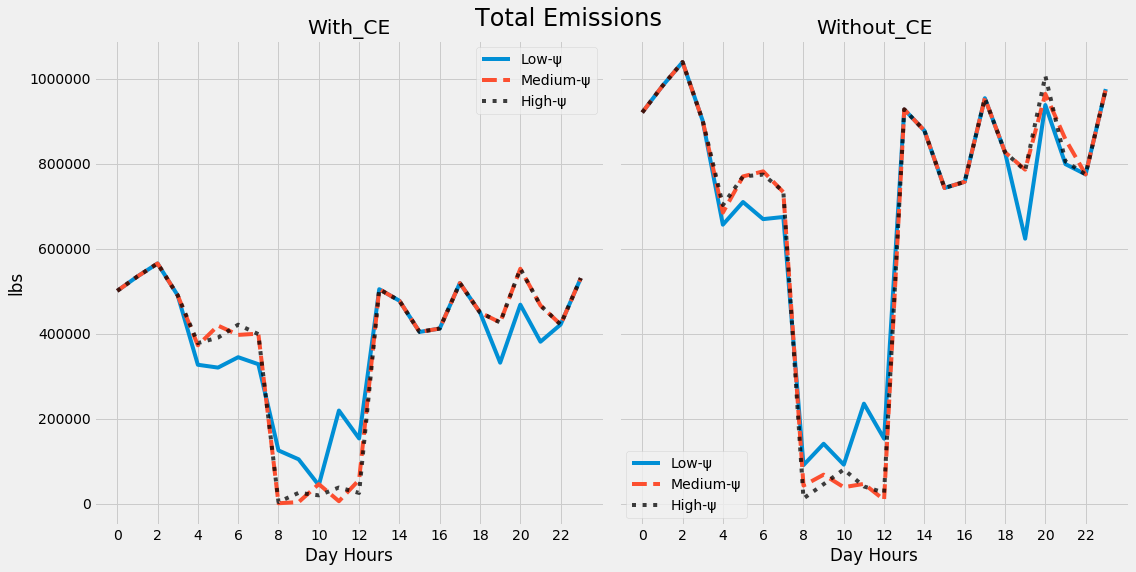

In [15]:
Profits_Actual_MCE = {}
Profits_Wghited_MCE = {}
Emission_Cost_MCE = {}
Retailer_Profits_MCE = {}

Profits_Actual_MWCE = {}
Profits_Wghited_MWCE = {}
Emission_Cost_MWCE = {}
Retailer_Profits_MWCE = {}

high_MCE_leader['Total_Emissions'] = high_MCE_leader['Coal_Emissions (lbs)'] + high_MCE_leader['Oil_Emissions (lbs)'] + high_MCE_leader['Gas_Emissions (lbs)']
med_MCE_leader['Total_Emissions'] = med_MCE_leader['Coal_Emissions (lbs)'] + med_MCE_leader['Oil_Emissions (lbs)'] + med_MCE_leader['Gas_Emissions (lbs)']
low_MCE_leader['Total_Emissions'] = low_MCE_leader['Coal_Emissions (lbs)'] + low_MCE_leader['Oil_Emissions (lbs)'] + low_MCE_leader['Gas_Emissions (lbs)']

high_MWCE_leader['Total_Emissions'] = high_MWCE_leader['Coal_Emissions (lbs)'] + high_MWCE_leader['Oil_Emissions (lbs)'] + high_MWCE_leader['Gas_Emissions (lbs)']
med_MWCE_leader['Total_Emissions'] = med_MWCE_leader['Coal_Emissions (lbs)'] + med_MWCE_leader['Oil_Emissions (lbs)'] + med_MWCE_leader['Gas_Emissions (lbs)']
low_MWCE_leader['Total_Emissions'] = low_MWCE_leader['Coal_Emissions (lbs)'] + low_MWCE_leader['Oil_Emissions (lbs)'] + low_MWCE_leader['Gas_Emissions (lbs)']


Emission_Cost_MCE['Low'] = sum(low_MCE_leader['Total_Emissions']*cost_emission)
Emission_Cost_MCE['Medium'] = sum(med_MCE_leader['Total_Emissions']*cost_emission)
Emission_Cost_MCE['High'] = sum(high_MCE_leader['Total_Emissions']*cost_emission)

Emission_Cost_MWCE['Low'] = sum(low_MWCE_leader['Total_Emissions']*cost_emission)
Emission_Cost_MWCE['Medium'] = sum(med_MWCE_leader['Total_Emissions']*cost_emission)
Emission_Cost_MWCE['High'] = sum(high_MWCE_leader['Total_Emissions']*cost_emission)

title_row = ['With CE', 'Without CE']
psi_labels = ['Low \u03C8', 'Medium \u03C8', 'High \u03C8']

fig, axes = plt.subplots(1,2, figsize=(16,8), constrained_layout=True, sharey='row', sharex= True)

axes[0].plot(low_MCE_leader['Total_Emissions'], label='Low-\u03C8', alpha= 1)
axes[0].plot(med_MCE_leader['Total_Emissions'], label='Medium-\u03C8', alpha= 1, ls='--')
axes[0].plot(high_MCE_leader['Total_Emissions'], label='High-\u03C8', alpha= 0.75, ls=':', c='k')
axes[0].set_ylabel('lbs')
axes[0].set_xlabel('Day Hours')
axes[0].set_xticks(np.arange(0, 24, step=2))
axes[0].legend()
axes[0].set_title('With_CE')

axes[1].plot(low_MWCE_leader['Total_Emissions'], label='Low-\u03C8', alpha= 1)
axes[1].plot(med_MWCE_leader['Total_Emissions'], label='Medium-\u03C8', alpha= 1, ls='--')
axes[1].plot(high_MWCE_leader['Total_Emissions'], label='High-\u03C8', alpha= 0.75, ls=':', c='k')
axes[1].set_xticks(np.arange(0, 24, step=2))
axes[1].set_xlabel('Day Hours')
axes[1].legend()
axes[1].set_title('Without_CE')

fig.suptitle(f'Total Emissions', fontsize=24);

plt.savefig('emissions.jpg',quality=95)